AB2 Method

In [1]:
# --- Cell 1: imports & core EOM ---
import numpy as np

def equations(t, y, rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi):
    """
    y = [x, vx, h, vy]
    坐标: x 水平位移, h 高度(>0 为空中), vx, vy 分别水平/竖直速度(向上为正)
    风: vw 为地面系水平风速, 相对风 = [vw - vx, -vy]
    力:
      - 伞阻: Cp * (π r^2) * 0.5 * rho * |urel|^2, 方向与相对风相反
      - 机体阻: 水平用 Cw * (L D), 竖直用 Cb * (π (D/2)^2)
      - 重力: m g 向下
      - 科氏力: 2Ω×v 的东西向分量 ~ ± 2 cos(phi) * omega * (·)
    """
    x, vx, h, vy = y

    # --- 相对风向量与单位向量 ---
    u = np.array([vw - vx, -vy], dtype=float)
    umag = np.hypot(u[0], u[1]) + 1e-12
    ux, uy = u / umag

    # --- 伞阻 (与相对风相反) ---
    A_par = pi * r**2
    F_par_mag = 0.5 * rho * (umag**2) * cp * A_par
    Fx_par = -F_par_mag * ux
    Fy_par = -F_par_mag * uy

    # --- 机体阻 (按分量平方) ---
    # 水平机体阻: 基于横向相对风 (vw - vx)
    A_body_x = L * D
    Fx_body = -0.5 * rho * (vw - vx) * abs(vw - vx) * cw * A_body_x

    # 竖直机体阻: 基于 vy
    A_body_y = pi * (D/2)**2
    Fy_body = -0.5 * rho * vy * abs(vy) * cb * A_body_y

    # --- 重力 ---
    Fy_grav = -m * g

    # --- 科氏项（近似保留主要分量）---
    # 地转近似：a_cor,x = -2 * omega * cos(phi) * vy
    #            a_cor,y = +2 * omega * cos(phi) * vx
    a_cor_x = -2.0 * np.cos(phi) * omega * vy
    a_cor_y = +2.0 * np.cos(phi) * omega * vx

    # --- 平动方程 ---
    ax = (Fx_par + Fx_body) / m + a_cor_x
    ay = (Fy_par + Fy_body + Fy_grav) / m + a_cor_y

    return np.array([vx, ax, vy, ay], dtype=float)


Trajectory Model using Solve_IVP

AB2 Trajectory Model

In [2]:
# --- Cell 2: AB2 with RK2 start + landing event (h crosses zero) ---

def simulate_ab2_until_land(dt, t_max, y0, args):
    """
    返回:
      t_land, y_land: 落地时刻与状态 (x, vx, h=0, vy)，若未落地则返回 (None, None)
      traj: (N, 5) 数组，列为 [t, x, vx, h, vy]
    说明:
      - 首步采用 Heun (RK2) 启动，保证整体二阶
      - 采用线性插值求 h=0 的落地事件
    """
    # 初始化
    t = 0.0
    y = y0.astype(float).copy()

    traj = []
    traj.append([t, y[0], y[1], y[2], y[3]])

    # --- RK2 启动 ---
    f0 = equations(t, y, *args)
    y_star = y + dt * f0
    f_star = equations(t + dt, y_star, *args)
    y1 = y + 0.5 * dt * (f0 + f_star)
    t1 = t + dt

    traj.append([t1, y1[0], y1[1], y1[2], y1[3]])

    # 准备 AB2 主循环
    f_prev = f0
    f_curr = equations(t1, y1, *args)
    t, y = t1, y1

    # 若已落地
    if traj[-2][3] > 0 and traj[-1][3] <= 0:
        t0, h0 = traj[-2][0], traj[-2][3]
        t1, h1 = traj[-1][0], traj[-1][3]
        alpha = h0 / (h0 - h1 + 1e-16)
        t_land = t0 + alpha * (t1 - t0)
        y_prev = np.array(traj[-2][1:5])
        y_curr = np.array(traj[-1][1:5])
        y_land = y_prev + alpha * (y_curr - y_prev)
        y_land[2] = 0.0
        return t_land, y_land, np.array(traj)

    # --- AB2 主循环 ---
    while t < t_max:
        y_new = y + dt * (1.5 * f_curr - 0.5 * f_prev)
        t_new = t + dt

        # 落地检测: h 从正到非正
        h_old, h_new = y[2], y_new[2]
        traj.append([t_new, y_new[0], y_new[1], y_new[2], y_new[3]])

        if h_old > 0.0 and h_new <= 0.0:
            # 线性插值落地
            alpha = h_old / (h_old - h_new + 1e-16)
            t_land = t + alpha * dt
            y_land = y + alpha * (y_new - y)
            y_land[2] = 0.0
            return t_land, y_land, np.array(traj)

        # 推进
        f_prev, f_curr = f_curr, equations(t_new, y_new, *args)
        t, y = t_new, y_new

    # 未落地
    return None, None, np.array(traj)


Verify rocket has landed (Altitude has crossed y = 0) before running next block

In [3]:
# --- Cell 3: search minimum parachute radius under |vy| constraint ---

def find_min_radius_ab2(rho, vw, cp, cb, cw, D, L, m, phi, g, omega, pi,
                        max_vy, x0, vx0, h0, vy0,
                        r0=0.005, dr=0.005, dt=0.01, t_max=300.0, r_max=10.0):
    """
    逐步增大 r，使用 AB2 落地仿真。若全程 |vy| < max_vy 则返回当前 r。
    增量 dr 单位: m。默认从 0.5 cm 半径开始。
    """
    r = r0
    while r <= r_max:
        args = (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi)
        y0 = np.array([x0, vx0, h0, vy0], dtype=float)
        t_land, y_land, traj = simulate_ab2_until_land(dt, t_max, y0, args)
        if t_land is None:
            # 未落地，可能 dt 太大或力场设置异常；放宽 t_max 或减小 dt 再试
            r += dr
            continue
        vy_all = traj[:, 4]
        if np.max(np.abs(vy_all)) < max_vy:
            return r
        r += dr
    raise RuntimeError("未在 r <= r_max 的范围内满足 |vy| 约束，请检查约束或增大 r_max。")


In [4]:
# --- Cell 4: interactive run (single simulation + optional search) ---

# 常量
rho = 1.225
g = 9.81
omega = 7.292e-5
pi = np.pi

# === 交互输入 ===
def _float(prompt):
    return float(input(prompt).strip())

# 运行模式：1=直接给伞半径并仿真；2=给最大允许|vy|并搜索最小伞半径
mode = int(input("选择模式: 1)给定伞半径仿真  2)搜索最小伞半径： ").strip() or "1")

vw0 = _float("Enter wind speed (m/s): ")
wsf = _float("Enter wind safety factor (e.g., 1~2): ")
vw = vw0 * wsf

cp = 1.3
cb = 0.8
cw = 1.0

if mode == 1:
    r = _float("Enter parachute radius (cm): ") / 100.0
else:
    # 占位初始化，实际由搜索得到
    r = 0.005

D = _float("Enter rocket body diameter (cm): ") / 100.0
L = _float("Enter rocket length (cm): ") / 100.0
m = _float("Enter rocket mass (g): ") / 1000.0
phi = np.deg2rad(_float("Enter launch site latitude (degrees): "))

x0 = 0.0
vx0 = _float("Enter horizontal velocity at apogee (m/s): ")
h00 = _float("Enter altitude at apogee (m): ")
hsf = _float("Enter altitude safety factor (e.g., 1 for nominal): ")
vy0 = -0.1

h0 = h00 * hsf

# 数值设置
if mode == 1:
    t_duration = _float("Enter simulation duration upper bound (s): ")
else:
    t_duration = _float("Enter simulation duration upper bound for search (s): ")
dt = t_duration / 1000.0
dt = max(1e-4, dt)  # 守护

args = (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi)
y0 = np.array([x0, vx0, h0, vy0], dtype=float)

if mode == 1:
    t_land, y_land, traj = simulate_ab2_until_land(dt, t_duration, y0, args)
    if t_land is None:
        print("Warning: 未在 t_max 内落地；请增大 t_max 或减小 dt。")
    else:
        xf, vxf, vyf = y_land[0], y_land[1], y_land[3]
        print(f"Total descent time: {t_land:.2f} s")
        print(f"Horizontal landing displacement: {xf:.2f} m")
        print(f"Horizontal landing speed: {vxf:.2f} m/s")
        print(f"Vertical landing speed: {vyf:.2f} m/s")
else:
    max_vy = abs(_float("Enter max allowable vertical speed (m/s), e.g. 2~5: "))
    min_r = find_min_radius_ab2(rho, vw, cp, cb, cw, D, L, m, phi, g, omega, pi,
                                max_vy, x0, vx0, h0, vy0,
                                r0=0.005, dr=0.005, dt=dt, t_max=t_duration, r_max=5.0)
    print(f"Minimum parachute radius required: {round(min_r*100, 1)} cm")
    # 用该半径再跑一次仿真，给出落地指标
    args = (rho, vw, cp, cb, cw, min_r, D, L, m, phi, g, omega, pi)
    t_land, y_land, traj = simulate_ab2_until_land(dt, t_duration, y0, args)
    if t_land is not None:
        xf, vxf, vyf = y_land[0], y_land[1], y_land[3]
        print(f"[With r*] Total descent time: {t_land:.2f} s")
        print(f"[With r*] Horizontal landing displacement: {xf:.2f} m")
        print(f"[With r*] Horizontal landing speed: {vxf:.2f} m/s")
        print(f"[With r*] Vertical landing speed: {vyf:.2f} m/s")


选择模式: 1)给定伞半径仿真  2)搜索最小伞半径： 1
Enter wind speed (m/s): 0
Enter wind safety factor (e.g., 1~2): 2
Enter parachute radius (cm): 20
Enter rocket body diameter (cm): 5
Enter rocket length (cm): 30
Enter rocket mass (g): 50
Enter launch site latitude (degrees): 0
Enter horizontal velocity at apogee (m/s): 10
Enter altitude at apogee (m): 100
Enter altitude safety factor (e.g., 1 for nominal): 1
Enter simulation duration upper bound (s): 5000
Total descent time: 3.38 s
Horizontal landing displacement: 1877.73 m
Horizontal landing speed: 4488985.55 m/s
Vertical landing speed: -220503.22 m/s


In [6]:
# --- Cell 5: plotting helpers ---
import matplotlib.pyplot as plt

def plot_trajectory(traj, rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi):
    t = traj[:, 0]
    x = traj[:, 1]
    vx = traj[:, 2]
    h = traj[:, 3]
    vy = traj[:, 4]

    # 计算加速度与相对风
    theta = np.arctan2(vw - vx, -vy)
    urel = vw - vx
    # 为了与原图类似，单独计算 ax, ay（用同一 equations 分解更一致）
    # 这里直接复用 equations 的力学写法
    ax = np.empty_like(vx)
    ay = np.empty_like(vy)
    for i in range(len(t)):
        _, ax[i], _, ay[i] = equations(t[i], np.array([x[i], vx[i], h[i], vy[i]]),
                                       rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi)

    plt.figure(figsize=(10, 8))
    plt.subplot(3, 2, 1)
    plt.plot(x, h)
    plt.xlabel('Horizontal Displacement (m)')
    plt.ylabel('Altitude (m)')
    plt.title('Trajectory')
    plt.grid(True)

    plt.subplot(3, 2, 2)
    plt.plot(t, x, label='Horizontal Displacement (m)')
    plt.plot(t, h, label='Altitude (m)')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title('Position vs Time')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 3)
    plt.plot(t, vx, label='Horizontal Velocity (m/s)')
    plt.plot(t, vy, label='Vertical Velocity (m/s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity vs Time')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 4)
    plt.plot(t, ax, label='Horizontal Acc ($m/s^2$)')
    plt.plot(t, ay, label='Vertical Acc ($m/s^2$)')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration ($m/s^2$)')
    plt.title('Acceleration vs Time')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 5)
    plt.plot(t, vw - vx)
    plt.xlabel('Time (s)')
    plt.ylabel('Relative Wind Speed (m/s)')
    plt.title('Air Speed ($v_w - v_x$)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [7]:
# --- Cell 6: error convergence study (order ~2 expected) ---

def reference_solution(y0, args, t_max, use_scipy=True):
    """
    参考解：
      - 优先 SciPy solve_ivp + 落地事件 (rtol=1e-10, atol=1e-12)
      - 若无 SciPy，则用 AB2 的细网格 dt_ref = t_max/20000 近似
    返回: t_ref, y_ref (落地状态)
    """
    if use_scipy:
        try:
            from scipy.integrate import solve_ivp
            def event_land(t, y): return y[2]
            event_land.terminal = True
            event_land.direction = -1
            sol = solve_ivp(lambda t, Y: equations(t, Y, *args),
                            (0.0, t_max), y0, events=event_land,
                            rtol=1e-10, atol=1e-12, max_step=t_max/10000)
            t_ref = float(sol.t_events[0][0])
            y_ref = sol.y_events[0][0].copy()
            y_ref[2] = 0.0
            return t_ref, y_ref
        except Exception:
            pass
    # 细网格 AB2
    dt_ref = max(1e-5, t_max / 20000.0)
    t_ref, y_ref, _ = simulate_ab2_until_land(dt_ref, t_max, y0, args)
    if t_ref is None:
        raise RuntimeError("参考解未落地，请检查参数或增大 t_max。")
    return t_ref, y_ref

def order_study(dt0, levels, y0, args, t_max, use_scipy=True, verbose=True):
    """
    生成 dt 序列: dt0, dt0/2, ..., dt0/2^(levels-1)
    误差指标: 落地时间、落地 x、vx、vy 相对参考解的绝对误差
    返回:
      dts: (L,) 步长数组
      errs: (L, 4) 各 dt 的误差数组 [E_t, E_x, E_vx, E_vy]
      p: (L-1, 4) 邻接阶数估计
    """
    t_ref, y_ref = reference_solution(y0, args, t_max, use_scipy=use_scipy)
    dts, errs = [], []
    dt = dt0
    for _ in range(levels):
        tL, yL, _ = simulate_ab2_until_land(dt, t_max, y0, args)
        if tL is None:
            raise RuntimeError(f"dt={dt} 未落地；请减小 dt 或增大 t_max")
        E = np.array([
            abs(tL - t_ref),
            abs(yL[0] - y_ref[0]),
            abs(yL[1] - y_ref[1]),
            abs(yL[3] - y_ref[3]),
        ], dtype=float)
        dts.append(dt); errs.append(E)
        dt *= 0.5
    dts = np.array(dts); errs = np.vstack(errs)

    # Richardson 阶数估计
    p = []
    for j in range(errs.shape[1]):
        pj = []
        for k in range(len(dts)-1):
            ratio = errs[k, j] / max(1e-30, errs[k+1, j])
            pj.append(np.log(ratio) / np.log(2.0))
        p.append(pj)
    p = np.array(p).T  # (L-1, 4)

    if verbose:
        hdr = "dt\t\tE_t\t\tE_x\t\tE_vx\t\tE_vy"
        print(hdr)
        for i in range(len(dts)):
            print(f"{dts[i]:.6f}\t{errs[i,0]:.3e}\t{errs[i,1]:.3e}\t{errs[i,2]:.3e}\t{errs[i,3]:.3e}")
        print("\nEstimated order p between successive dt (expect ~2):")
        print("p_t\tp_x\tp_vx\tp_vy")
        for row in p:
            print("\t".join(f"{val:.2f}" for val in row))
    return dts, errs, p


In [8]:
# --- Cell 7: one-at-a-time finite-difference sensitivity ---

PARAM_ORDER = ["rho","vw","cp","cb","cw","r","D","L","m","phi","g","omega","pi"]

def land_outputs(dt, tmax, y0, args):
    tL, yL, _ = simulate_ab2_until_land(dt, tmax, y0, args)
    if tL is None:
        raise RuntimeError("未落地，无法计算输出敏感性。")
    return {"t": tL, "x": yL[0], "vx": yL[1], "vy": yL[3]}

def finite_sensitivity(param_name, base_args, y0, dt, tmax, rel_delta=0.05, abs_delta=None):
    """
    对 base_args 中的某个参数做 +/- 扰动，计算输出导数近似:
      d(output)/d(param) ≈ (f(+)-f(-)) / (2*Δ)
    rel_delta: 相对扰动（默认 5%）
    abs_delta: 绝对扰动（若提供则优先使用）
    返回: base_out, sens (每个输出分量的导数近似)
    """
    idx = PARAM_ORDER.index(param_name)
    base_out = land_outputs(dt, tmax, y0, base_args)
    a = list(base_args)

    # 选择扰动幅度
    if abs_delta is not None:
        delta = abs_delta
    else:
        delta = rel_delta * (a[idx] if param_name != "pi" else 1.0)

    a_plus  = list(a); a_minus = list(a)
    a_plus[idx]  = a[idx] + delta
    a_minus[idx] = a[idx] - delta

    out_plus  = land_outputs(dt, tmax, y0, tuple(a_plus))
    out_minus = land_outputs(dt, tmax, y0, tuple(a_minus))
    sens = {k: (out_plus[k] - out_minus[k]) / (2.0 * delta) for k in base_out}
    return base_out, sens


dt		E_t		E_x		E_vx		E_vy
0.040000	9.013e-02	1.671e+02	1.408e+09	2.277e+08
0.020000	2.453e-02	7.197e+01	4.133e+09	7.781e+08
0.010000	1.946e-02	4.555e+01	1.501e+09	2.920e+08
0.005000	3.725e-02	1.022e+02	3.170e+09	6.061e+08

Estimated order p between successive dt (expect ~2):
p_t	p_x	p_vx	p_vy
1.88	1.22	-1.55	-1.77
0.33	0.66	1.46	1.41
-0.94	-1.17	-1.08	-1.05

--- Landing metrics (dt=0.01) ---
Descent time: 0.25 s | x_land: -2596.63 m | vx: -2876107409.21 m/s | vy: -533634773.78 m/s


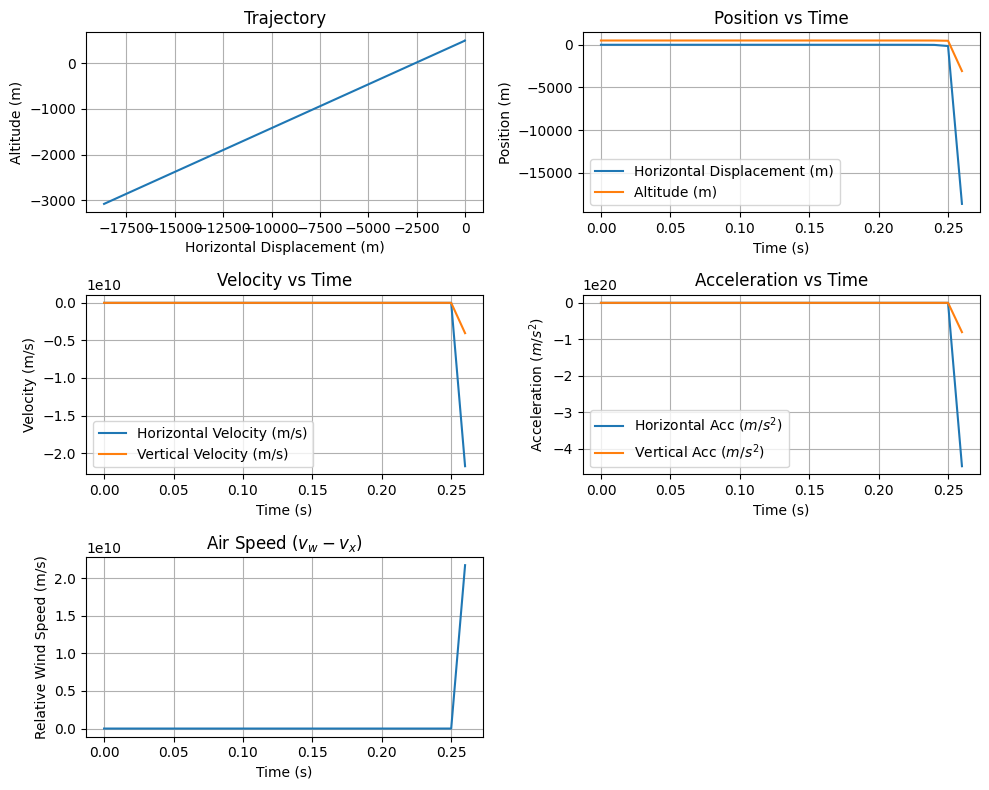

In [9]:
# --- Cell 8: quick demo (adjust numbers as needed) ---

# 基本参数（可改）
rho = 1.225; g = 9.81; omega = 7.292e-5; pi = np.pi
vw = 10.0 * 1.5     # 风 10 m/s, WSF=1.5
cp, cb, cw = 1.3, 0.8, 1.0
r = 0.6             # 0.6 m 半径
D, L = 0.10, 0.50   # 10 cm 直径, 50 cm 长度
m = 1.0             # 1 kg
phi = np.deg2rad(20.0)

args = (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi)
y0 = np.array([0.0, 10.0, 500.0, -0.1], dtype=float)

# 收敛研究
dts, errs, p = order_study(dt0=0.04, levels=4, y0=y0, args=args, t_max=300.0, use_scipy=True, verbose=True)

# 单次仿真 + 画图
t_land, y_land, traj = simulate_ab2_until_land(dt=0.01, t_max=300.0, y0=y0, args=args)
print("\n--- Landing metrics (dt=0.01) ---")
print(f"Descent time: {t_land:.2f} s | x_land: {y_land[0]:.2f} m | vx: {y_land[1]:.2f} m/s | vy: {y_land[3]:.2f} m/s")

plot_trajectory(traj, *args)
